In [21]:
import math

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

In [7]:
data = pd.read_csv('./extract_seoul.csv')

In [9]:
data = data.drop(['Unnamed: 0'],1)

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 30 columns):
Date               188 non-null datetime64[ns]
Total              188 non-null float64
Seoul              188 non-null float64
Northern seoul     188 non-null float64
Gangbuk-gu         188 non-null float64
Gwangjin-gu        188 non-null float64
Nowon-gu           188 non-null float64
Dobong-gu          188 non-null float64
Dongdaemun-gu      188 non-null float64
Mapo-gu            188 non-null float64
Seodaemun-gu       188 non-null float64
Seongdong-gu       188 non-null float64
Seongbuk-gu        188 non-null float64
Yongsan-gu         188 non-null float64
Eunpyeong-gu       188 non-null float64
Jongno-gu          188 non-null float64
Jung-gu            188 non-null float64
Jungnang-gu        188 non-null float64
Southern Seoul     188 non-null float64
Gangnam-gu         188 non-null float64
Gangdong-gu        188 non-null float64
Gangseo-gu         188 non-null float64
Gwanak-g

In [12]:
GU_ENG_NAME = ''

### Dict 관련 함수 선언

In [13]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [14]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [15]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### 원하는 구만 선택하기

In [16]:
def select_gu_data(df, gu_name):
    gu_name += '-gu'
    global GU_ENG_NAME
    
    GU_ENG_NAME = gu_name
    
    return df[['Date', gu_name]]
    

In [17]:
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

In [19]:
gangnam = select_gu_data(data, 'Gangnam')
print(GU_ENG_NAME)

Gangnam-gu


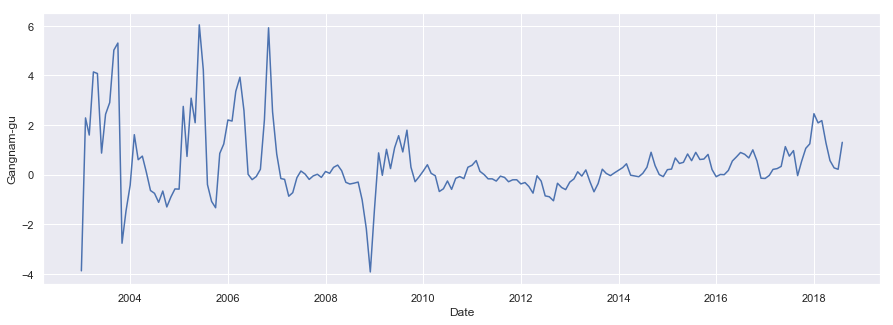

In [20]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gangnam)

### Keras import

In [621]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from keras.regularizers import L1L2

In [23]:
gangnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date          188 non-null datetime64[ns]
Gangnam-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [24]:
mask = pd.to_datetime('2010-01-01')
tmp = gangnam.loc[:][gangnam['Date'] >= mask]

In [25]:
gangnam_tmp = tmp.drop('Date', 1)

In [26]:
gangnam_tmp

,Gangnam-gu
84,0.146998
85,0.401215
86,0.054086
87,-0.042543
88,-0.678413
89,-0.567626
90,-0.254231
91,-0.591100
92,-0.146213
93,-0.075991


### Normalize

In [437]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(gangnam_tmp)

In [438]:
dataset[:5]

array([[0.34161309],
       [0.41399694],
       [0.31515787],
       [0.28764442],
       [0.10659095]])

In [439]:
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (83, 21)


In [440]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [441]:
window_size = 4

In [442]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

whole_X, whole_Y = create_dataset(dataset, window_size)
print("Original training data shape:")
print(whole_X.shape)
print(whole_Y.shape)

Original training data shape:
(99, 4)
(99,)


In [443]:
train_Y[:10]

array([0.10659095, 0.13813561, 0.22736977, 0.13145184, 0.25812596,
       0.27812051, 0.25453416, 0.38518202, 0.40807148, 0.4620269 ])

In [444]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

New training data shape:
(78, 1, 4)


In [599]:
MODEL_PATH = ''


if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    print("Model_path : ", MODEL_PATH)
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

In [692]:
def Model(train_X, train_Y, window_size = 1):
    model = Sequential()
#     model.add(LSTM(12,return_sequences=True, input_shape = (1, window_size)))
    model.add(LSTM ( 256,  activation = 'relu', inner_activation = 'hard_sigmoid' , bias_regularizer=L1L2(l1=0.01, l2=0.01),  input_shape =(1, window_size), return_sequences = False ))
#     model.add(LSTM(12,return_sequences=True))
#     model.add(LSTM(12))
    model.add(Dense(1))
    
#     adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(train_X, train_Y, epochs = 500 ,batch_size=4, validation_split = 0.1,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [693]:
model = Model(train_X, train_Y, window_size)

/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(256, activation="relu", bias_regularizer=<keras.reg..., input_shape=(1, 4), return_sequences=False, recurrent_activation="hard_sigmoid")`


Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 70 samples, validate on 8 samples
Epoch 1/500
70/70 [==============================] - 7s 97ms/step - loss: 5.1359 - val_loss: 5.1132

Epoch 00001: val_loss improved from inf to 5.11318, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-5.113177.hdf5
Epoch 2/500
70/70 [==============================] - 0s 3ms/step - loss: 4.9620 - val_loss: 4.9084

Epoch 00002: val_loss improved from 5.11318 to 4.90841, saving model to ./TimeSeries/LSTM/Gangnam-gu/val

70/70 [==============================] - 0s 2ms/step - loss: 1.7053 - val_loss: 1.6672

Epoch 00034: val_loss improved from 1.73821 to 1.66723, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.667227.hdf5
Epoch 35/500
70/70 [==============================] - 0s 2ms/step - loss: 1.6352 - val_loss: 1.5999

Epoch 00035: val_loss improved from 1.66723 to 1.59992, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.599920.hdf5
Epoch 36/500
70/70 [==============================] - 0s 2ms/step - loss: 1.5670 - val_loss: 1.5310

Epoch 00036: val_loss improved from 1.59992 to 1.53103, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.531031.hdf5
Epoch 37/500
70/70 [==============================] - 0s 3ms/step - loss: 1.5005 - val_loss: 1.4644

Epoch 00037: val_loss improved from 1.53103 to 1.46445, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-1.464450.hdf5
Epoch 38/500
70/70 [==============================] - 0s 2ms/step - loss: 1.4353 - val_loss: 1.4015

Epoch 00038:

70/70 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0144

Epoch 00071: val_loss improved from 0.03865 to 0.01442, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.014416.hdf5
Epoch 72/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0100 - val_loss: 0.0073

Epoch 00072: val_loss improved from 0.01442 to 0.00734, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.007344.hdf5
Epoch 73/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0067

Epoch 00073: val_loss improved from 0.00734 to 0.00674, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.006742.hdf5
Epoch 74/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0082

Epoch 00074: val_loss did not improve from 0.00674
Epoch 75/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0075

Epoch 00075: val_loss did not improve from 0.00674
Epoch 76/500
70/70 [==============

70/70 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0076

Epoch 00123: val_loss did not improve from 0.00644
Epoch 124/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0080

Epoch 00124: val_loss did not improve from 0.00644
Epoch 125/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0089

Epoch 00125: val_loss did not improve from 0.00644
Epoch 126/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0088

Epoch 00126: val_loss did not improve from 0.00644
Epoch 127/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0070

Epoch 00127: val_loss did not improve from 0.00644
Epoch 128/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0083

Epoch 00128: val_loss did not improve from 0.00644
Epoch 129/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.

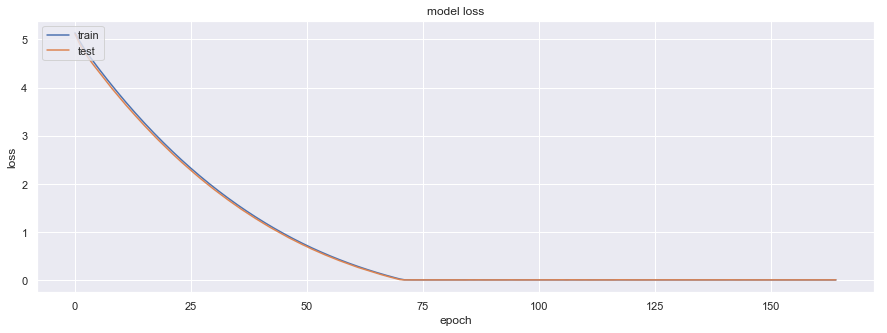

In [694]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
 
T=25
history_val_loss=[]
 
for x in model[1].history['val_loss']:
    if x >= T:
        history_val_loss.append (T)
    else:
        history_val_loss.append( x )
        
plt.figure(figsize = (15, 5))
plt.plot(model[1].history['loss'])
plt.plot(history_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [695]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(len(orig_data[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data)

In [760]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [761]:
rmse_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)

whole_test, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Whole data score: %.2f RMSE " % whole_test)

78
78
16
16
99
99
Training data score: 0.21 RMSE
Test data score: 0.87 RMSE
Whole data score: 0.41 RMSE 


In [763]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

5306.062538665961

In [764]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    
    ##땡기자
    print("window_size: ", window_size)
    train_predict_plot[(window_size - 1) : len(train_predict) + (window_size - 1)] = train_predict

    
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
#     test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1] = test_predict
    test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict
    
    print(test_predict_plot.shape)
    print(whole_predict.shape)

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
    plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

window_size:  4
(104, 1)
(99, 1)


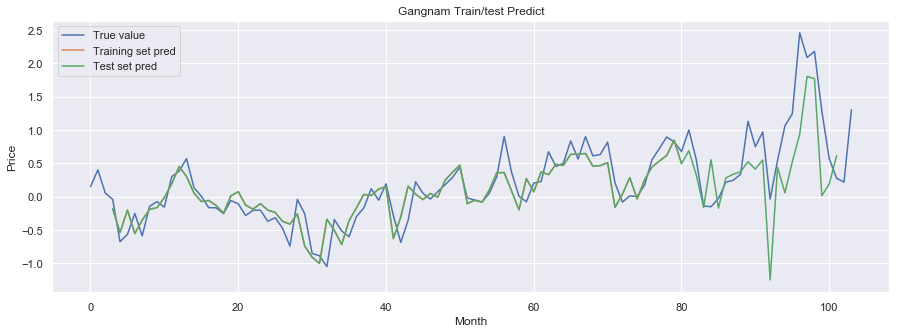

In [765]:
start_predict_n_plot(dataset, train_predict, test_predict)

In [701]:
len(train_X)

78

In [702]:
len(whole_predict)

99

In [703]:
whole_predict[-window_size:].shape

(4, 1)

In [704]:
whole_predict[-window_size:]

array([[1.8294083 ],
       [0.62144417],
       [0.2265584 ],
       [0.2621126 ]], dtype=float32)

In [705]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [706]:
len(whole_predict)

99

In [707]:
future_pred = predict_future(model[0], whole_predict, window_size)

X shape:  (99, 1)
trans:  [[1.8294083  0.62144417 0.2265584  0.2621126 ]]
trans shape:  (1, 4)
tmp_shape:  [[[1.8294083  0.62144417 0.2265584  0.2621126 ]]]
pred:  [[0.81448716]]


In [708]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [709]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

len before:  100
X shape:  (100, 1)
trans:  [[0.62144417 0.2265584  0.2621126  0.81448716]]
trans shape:  (1, 4)
tmp_shape:  [[[0.62144417 0.2265584  0.2621126  0.81448716]]]
pred:  [[0.5150957]]
future_pred
[[0.5150957]]
len before:  101
X shape:  (101, 1)
trans:  [[0.2265584  0.2621126  0.81448716 0.5150957 ]]
trans shape:  (1, 4)
tmp_shape:  [[[0.2265584  0.2621126  0.81448716 0.5150957 ]]]
pred:  [[0.3094806]]
future_pred
[[0.3094806]]
len before:  102
X shape:  (102, 1)
trans:  [[0.2621126  0.81448716 0.5150957  0.3094806 ]]
trans shape:  (1, 4)
tmp_shape:  [[[0.2621126  0.81448716 0.5150957  0.3094806 ]]]
pred:  [[0.2606896]]
future_pred
[[0.2606896]]
len before:  103
X shape:  (103, 1)
trans:  [[0.81448716 0.5150957  0.3094806  0.2606896 ]]
trans shape:  (1, 4)
tmp_shape:  [[[0.81448716 0.5150957  0.3094806  0.2606896 ]]]
pred:  [[0.29920673]]
future_pred
[[0.29920673]]
len before:  104
X shape:  (104, 1)
trans:  [[0.5150957  0.3094806  0.2606896  0.29920673]]
trans shape:  (1, 

In [710]:
whole_predict

array([[-0.04367756],
       [-0.5402913 ],
       [-0.38385484],
       [-0.23703828],
       [-0.44078043],
       [-0.10386303],
       [-0.12904698],
       [-0.0726964 ],
       [ 0.23490773],
       [ 0.2777699 ],
       [ 0.4648999 ],
       [ 0.06133492],
       [-0.01615042],
       [-0.11660254],
       [-0.11003099],
       [-0.18946064],
       [-0.01299323],
       [-0.05282864],
       [-0.20310728],
       [-0.13021381],
       [-0.12964159],
       [-0.26937762],
       [-0.21195781],
       [-0.35288593],
       [-0.55119413],
       [-0.09307674],
       [-0.3463853 ],
       [-0.68870336],
       [-0.65719765],
       [-0.5737895 ],
       [-0.4068915 ],
       [-0.60839957],
       [-0.41492555],
       [-0.21066621],
       [-0.17297822],
       [ 0.04772437],
       [-0.00794523],
       [ 0.17871594],
       [-0.26849023],
       [-0.5334034 ],
       [-0.17864518],
       [-0.07445356],
       [-0.03779932],
       [ 0.01610872],
       [ 0.07949515],
       [ 0

In [711]:
def whole_predict_n_plot(dataset, train_predict):
    
    true_value_plot = np.empty_like(dataset)
    print(true_value_plot.shape)
    print(whole_predict.shape)
    
    print('dataset_len : ', len(dataset))
    print('whole_predict_len : ', len(whole_predict))
    
    
#     test_predict_plot[:, :] = np.nan
#     test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict

    whole_predict_plot = np.empty_like(dataset)
    whole_predict_plot[:, :] = np.nan
    whole_predict_plot[3: len(whole_predict) - (window_size + 3), :] = whole_predict[: len(whole_predict) - (window_size + 6)]
    

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

(104, 1)
(110, 1)
dataset_len :  104
whole_predict_len :  110


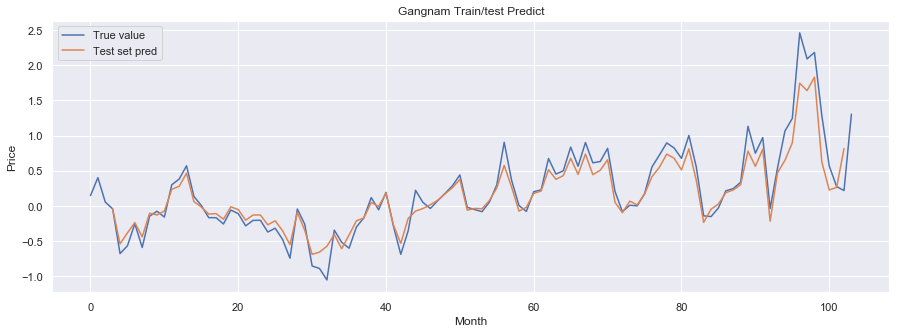

In [712]:
whole_predict_n_plot(dataset, train_predict)

(104, 1)
(110, 1)
dataset_len :  104
whole_predict_len :  110


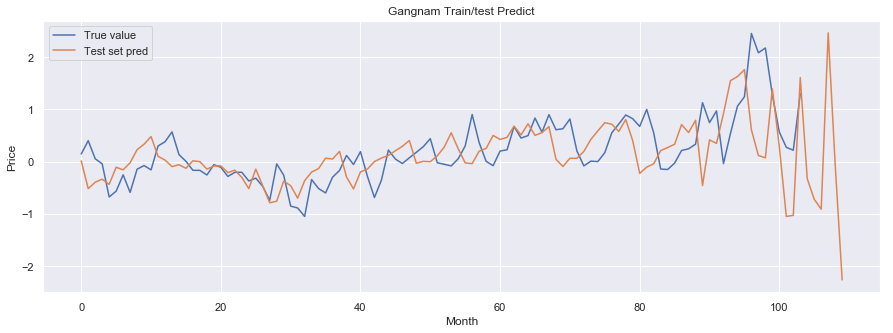

In [643]:
whole_predict_n_plot(dataset, train_predict)

In [749]:
def get_best_weights_path():
#     result = MODEL_PATH +"/"+sorted(os.listdir(MODEL_PATH))[0]

    result = './TimeSeries/LSTM/Gangnam-gu/val_loss-0.006086.hdf5'
    print("best model path: ", result)
    
    return result

In [750]:
best_weights = get_best_weights_path()

best model path:  ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.006086.hdf5


In [751]:
model[0].load_weights(best_weights)

In [767]:
def run_loaded_model(model, train_X, train_Y, window_size = 1):
#     adam = Adam(lr=0.00146, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)
    adam = Adam(lr=0.001, beta_1=0.89, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)
    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    history = model.fit(train_X, train_Y, epochs = 1000 ,batch_size=4, validation_split = 0.2,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [768]:
loaded_model = run_loaded_model(model[0], train_X, train_Y, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 256)               267264    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 62 samples, validate on 16 samples
Epoch 1/1000
62/62 [==============================] - 7s 109ms/step - loss: 0.0065 - val_loss: 0.0066

Epoch 00001: val_loss improved from inf to 0.00660, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.006601.hdf5
Epoch 2/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0067

Epoch 00002: val_loss did not improve from 0.00660
Epoch 3/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.0041 

62/62 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0075

Epoch 00049: val_loss did not improve from 0.00612
Epoch 50/1000
62/62 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0076

Epoch 00050: val_loss did not improve from 0.00612
Epoch 51/1000
62/62 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0079

Epoch 00051: val_loss did not improve from 0.00612
Epoch 52/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0077

Epoch 00052: val_loss did not improve from 0.00612
Epoch 53/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0070

Epoch 00053: val_loss did not improve from 0.00612
Epoch 54/1000
62/62 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0071

Epoch 00054: val_loss did not improve from 0.00612
Epoch 55/1000
62/62 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.

In [782]:
def mape(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(Y)
    
    Y, pred = np.array(Y), np.array(pred)
    
    return np.mean(np.abs((Y - pred) / Y) * 100)

In [769]:
rmse_train_score, train_predict, train_orig = predict_and_score(loaded_model[0], train_X, train_Y)
rmse_test_score, test_predict, test_orig = predict_and_score(loaded_model[0], test_X, test_Y)

whole_test_score, whole_predict, whole_orig = predict_and_score(loaded_model[0], whole_X, whole_Y)


print(whole_X[:5])
print(whole_Y[:5])
print('\n')
print("Training data score: %.2f RMSE" % rmse_train_score)
print("Test data score: %.2f RMSE" % rmse_test_score)
print("Whole data score: %.2f RMSE " % whole_test_score)

78
78
16
16
99
99
[[[0.34161309 0.41399694 0.31515787 0.28764442]]

 [[0.41399694 0.31515787 0.28764442 0.10659095]]

 [[0.31515787 0.28764442 0.10659095 0.13813561]]

 [[0.28764442 0.10659095 0.13813561 0.22736977]]

 [[0.10659095 0.13813561 0.22736977 0.13145184]]]
[0.10659095 0.13813561 0.22736977 0.13145184 0.25812596]


Training data score: 0.20 RMSE
Test data score: 0.88 RMSE
Whole data score: 0.41 RMSE 


In [783]:
mape(loaded_model[0], whole_X, whole_Y)

[0.10659095 0.13813561 0.22736977 0.13145184 0.25812596 0.27812051
 0.25453416 0.38518202 0.40807148 0.4620269  0.33802372 0.30129167
 0.25218556 0.25185434 0.22652257 0.28290495 0.26834486 0.21884845
 0.24098452 0.24156698 0.19396314 0.2093965  0.16411628 0.08794883
 0.28715331 0.22577299 0.05649797 0.04641818 0.         0.20161524
 0.15261872 0.12839877 0.21444004 0.25118653 0.33334945 0.28397418
 0.35422305 0.21846023 0.1035275  0.19847166 0.36285748 0.31389134
 0.28915095 0.32058684 0.35040944 0.38134575 0.42511862 0.29389887
 0.28488724 0.27628444 0.31520855 0.38508898 0.55716881 0.40362303
 0.30120879 0.2773862  0.35730569 0.36433045 0.49143759 0.42841529
 0.44176772 0.53767965 0.46023509 0.55624173 0.47401032 0.47940637
 0.53259242 0.3582441  0.2762441  0.30230675 0.29977363 0.34882988
 0.45702492 0.50500588 0.55460901 0.53408034 0.49204532 0.58487411
 0.45765257 0.25938263 0.25646361 0.29139648 0.36069062 0.3696295
 0.39489294 0.62186079 0.51272798 0.57618473 0.28876648 0.45369

/Users/tax_k/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide


inf

In [770]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

5570.507656967058

In [771]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [772]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

len before:  100
X shape:  (100, 1)
trans:  [[-0.32526183  0.22763701  0.57342637  0.3794627 ]]
trans shape:  (1, 4)
tmp_shape:  [[[-0.32526183  0.22763701  0.57342637  0.3794627 ]]]
pred:  [[0.06590873]]
future_pred
[[0.06590873]]
len before:  101
X shape:  (101, 1)
trans:  [[0.22763701 0.57342637 0.3794627  0.06590873]]
trans shape:  (1, 4)
tmp_shape:  [[[0.22763701 0.57342637 0.3794627  0.06590873]]]
pred:  [[-0.11943325]]
future_pred
[[-0.11943325]]
len before:  102
X shape:  (102, 1)
trans:  [[ 0.57342637  0.3794627   0.06590873 -0.11943325]]
trans shape:  (1, 4)
tmp_shape:  [[[ 0.57342637  0.3794627   0.06590873 -0.11943325]]]
pred:  [[0.14085573]]
future_pred
[[0.14085573]]
len before:  103
X shape:  (103, 1)
trans:  [[ 0.3794627   0.06590873 -0.11943325  0.14085573]]
trans shape:  (1, 4)
tmp_shape:  [[[ 0.3794627   0.06590873 -0.11943325  0.14085573]]]
pred:  [[-0.06371328]]
future_pred
[[-0.06371328]]
len before:  104
X shape:  (104, 1)
trans:  [[ 0.06590873 -0.11943325  0.140

(104, 1)
(110, 1)
dataset_len :  104
whole_predict_len :  110


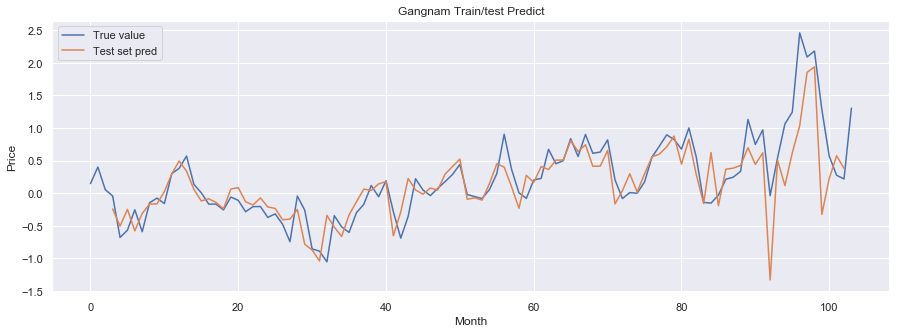

In [773]:
whole_predict_n_plot(dataset, train_predict)